# Машинне навчання
# Лабораторна робота №5
# Вишотравка Діана СА-33
## Варіант 4

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sp
from sklearn.preprocessing import TargetEncoder, StandardScaler, LabelEncoder, OrdinalEncoder, MinMaxScaler, OneHotEncoder, FunctionTransformer, OneHotEncoder
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import  accuracy_score, precision_recall_fscore_support, classification_report, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score
from sklearn.linear_model import SGDClassifier, LinearRegression, Lasso, Ridge
from sklearn_pandas import DataFrameMapper, gen_features
from sklearn.svm import SVC, SVR, LinearSVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping
from eds import *

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(rc={'figure.figsize': (15 , 10.5 ),
                  "lines.linewidth": 2.5}, font_scale=1.5)
palette = ['#2f6142','#69e0ab', '#80e0dc', '#0ca69f', '#046091', '#877ff0', '#6a4280', '#f5a6e1', '#7a1160']
sns.set_palette(palette)

In [66]:
def conf_matrix(y_true: pd.Series | np.ndarray, y_pred: pd.Series | np.ndarray, **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            colorbar=False, ax=axes[0], **kwargs)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize= 'true',
                                            colorbar=False, ax = axes[1], **kwargs)
    axes[1].set_title('Normalized by recall')
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize= 'pred',
                                            colorbar=False, ax = axes[2], **kwargs)
    axes[2].set_title('Normalized by precision')
    plt.rcParams.update({'font.size': 40})
    plt.tight_layout()
    return fig, axes

In [90]:
def report(y_true: pd.Series | np.ndarray, y_pred: pd.Series | np.ndarray) -> dict[str, float]:
    return ({
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='macro'),
        'Recall': recall_score(y_true, y_pred, average='macro'),
        'F-score': f1_score(y_true, y_pred, average='macro'),
    })

In [19]:
df_forestfires = pd.read_csv(r'forestfires.csv')
df_forestfires.drop_duplicates(inplace=True)
df_diabetes = pd.read_csv(r'diabetes_data.csv')
df_diabetes.drop_duplicates(inplace=True)
df_steel = pd.read_csv(r'Steel_industry.csv')
df_steel['Date_Time'] = pd.to_datetime(df_steel['Date_Time'], format='mixed')

## Data splitting

In [20]:
x_train_forest, x_test_forest, y_train_forest, y_test_forest = train_test_split(df_forestfires.loc[:, [i != 'area' for i in df_forestfires.columns.to_list()]], df_forestfires.loc[:, ['area']], test_size=0.2, random_state=113131313)

In [21]:
x_train_diabetes, x_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(df_diabetes.loc[:, [i != 'Diabetes' for i in df_diabetes.columns.to_list()]], df_diabetes.loc[:, ['Diabetes']], test_size=0.2, random_state=113131313)

In [22]:
x_train_steel, x_test_steel, y_train_steel, y_test_steel = train_test_split(df_steel.loc[:, [i != 'Load_Type' for i in df_steel.columns]], df_steel['Load_Type'], test_size=0.1, random_state=42)

## Random Forest (Steel industry)

### Preprocessing

In [93]:
dt_mapper = DataFrameMapper(
        gen_features(
        columns=[['Date_Time']],
        classes=[MonthExtractor, {'class': TargetEncoder,
                                  'target_type': 'multiclass'}],
        prefix='month_'
    ) + gen_features(
        columns=[['Date_Time']],
        classes=[DayExtractor, {'class': TargetEncoder,
                                'target_type': 'multiclass'}],
        prefix='day_'
    )+ gen_features(
        columns=[['WeekStatus'], ['Day_Of_Week']],
        classes=[{'class': TargetEncoder,
                                  'target_type': 'multiclass'}]
    ),
    df_out=True,
    default=None
)

dt_mapper.fit(x_train_steel, y_train_steel)

DataFrameMapper(default=None, df_out=True, drop_cols=[],
                features=[(['Date_Time'],
                           [<eds.MonthExtractor object at 0x000001F6006B5870>,
                            TargetEncoder(target_type='multiclass')],
                           {'prefix': 'month_'}),
                          (['Date_Time'],
                           [<eds.DayExtractor object at 0x000001F6006B4520>,
                            TargetEncoder(target_type='multiclass')],
                           {'prefix': 'day_'}),
                          (['WeekStatus'],
                           [TargetEncoder(target_type='multiclass')], {}),
                          (['Day_Of_Week'],
                           [TargetEncoder(target_type='multiclass')], {})])

In [24]:
template_rforest = RandomForestClassifier(n_jobs= -1, verbose=1, warm_start=True)

distributions = dict(
    n_estimators=[i for i in range(100, 501, 50)],
    max_features=sp.uniform(loc=0, scale=1),
    max_samples=sp.uniform(loc=0, scale=0.5),
    criterion=['gini', 'entropy', 'log_loss'],
    max_depth=[i for i in range(3, 9)]
)
rforest_selector = RandomizedSearchCV(template_rforest, distributions, n_jobs=-1, cv=5, verbose=1, n_iter=100, random_state=42)
rforest_model = rforest_selector.fit(dt_mapper.transform(x_test_steel), y_test_steel).best_estimator_
rforest_model

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.8s finished


RandomForestClassifier(max_depth=8, max_features=0.9717820827209607,
                       max_samples=0.4812236474710556, n_estimators=400,
                       n_jobs=-1, verbose=1, warm_start=True)

In [25]:
print(classification_report(y_test_steel, rforest_model.predict(dt_mapper.transform(x_test_steel)), digits=4))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.0s finished


              precision    recall  f1-score   support

  Light_Load     0.9885    0.9962    0.9923      1819
Maximum_Load     0.8760    0.8784    0.8772       732
 Medium_Load     0.9030    0.8878    0.8953       954

    accuracy                         0.9421      3505
   macro avg     0.9225    0.9208    0.9216      3505
weighted avg     0.9418    0.9421    0.9419      3505


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.2s finished


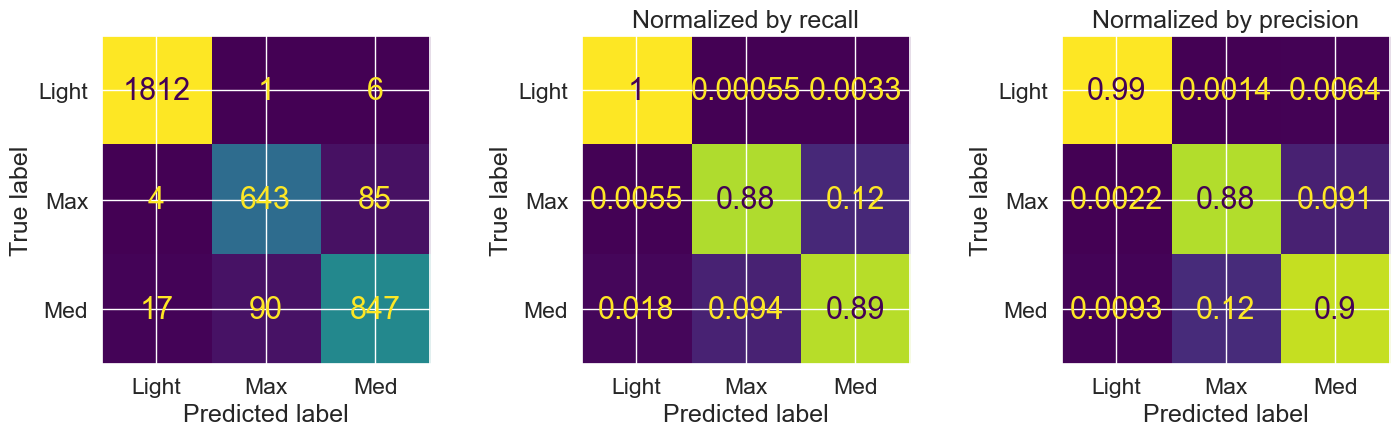

In [67]:
conf_matrix(y_test_steel, rforest_model.predict(dt_mapper.transform(x_test_steel)), display_labels = ['Light', 'Max', 'Med'])
plt.show()

### Feature importance

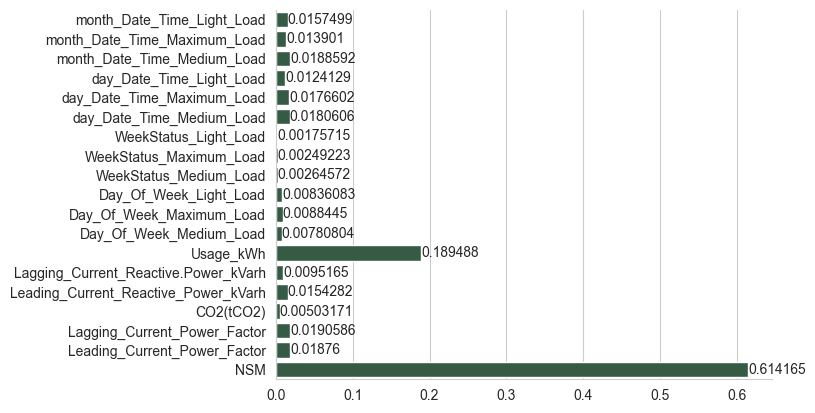

In [26]:
f = sns.barplot(x=rforest_model.feature_importances_,
                y=rforest_model.feature_names_in_)
f.bar_label(f.containers[0], fontsize=10)
sns.despine()
plt.show()

### Drop some features

In [86]:
dt_mapper = DataFrameMapper(
        gen_features(
        columns=[['Date_Time']],
        classes=[MonthExtractor, {'class': TargetEncoder,
                                  'target_type': 'multiclass'}],
        prefix='month_'
    ) + gen_features(
        columns=[['Date_Time']],
        classes=[DayExtractor, {'class': TargetEncoder,
                                'target_type': 'multiclass'}],
        prefix='day_'
    )+ gen_features(
        columns=[['Day_Of_Week']],
        classes=[{'class': TargetEncoder,
                                  'target_type': 'multiclass'}]
    ),
    df_out=True,
    drop_cols=['WeekStatus'],
    default=None
)

dt_mapper.fit(x_train_steel, y_train_steel)

DataFrameMapper(default=None, df_out=True, drop_cols=['WeekStatus'],
                features=[(['Date_Time'],
                           [<eds.MonthExtractor object at 0x000001F6006B4130>,
                            TargetEncoder(target_type='multiclass')],
                           {'prefix': 'month_'}),
                          (['Date_Time'],
                           [<eds.DayExtractor object at 0x000001F6006B79A0>,
                            TargetEncoder(target_type='multiclass')],
                           {'prefix': 'day_'}),
                          (['Day_Of_Week'],
                           [TargetEncoder(target_type='multiclass')], {})])

In [87]:
template_Rforest = RandomForestClassifier(n_jobs= -1, verbose=1, warm_start=True)

distributions = dict(
    n_estimators=[i for i in range(100, 501, 50)],
    max_features=sp.uniform(loc=0, scale=1),
    max_samples=sp.uniform(loc=0, scale=0.5),
    criterion=['gini', 'entropy', 'log_loss'],
    max_depth=[i for i in range(3, 9)]
)
rForest_selector = RandomizedSearchCV(template_Rforest, distributions, n_jobs=-1, cv=5, verbose=1, n_iter=100, random_state=42)
rForest_model = rForest_selector.fit(dt_mapper.transform(x_test_steel), y_test_steel).best_estimator_
rforest_model

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.1s finished


RandomForestClassifier(max_depth=8, max_features=0.9717820827209607,
                       max_samples=0.4812236474710556, n_estimators=400,
                       n_jobs=-1, verbose=1, warm_start=True)

In [88]:
print(classification_report(y_test_steel, rForest_model.predict(dt_mapper.transform(x_test_steel)), digits=4))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.2s finished


              precision    recall  f1-score   support

  Light_Load     0.9869    0.9973    0.9921      1819
Maximum_Load     0.8753    0.8825    0.8789       732
 Medium_Load     0.9085    0.8847    0.8964       954

    accuracy                         0.9427      3505
   macro avg     0.9236    0.9215    0.9225      3505
weighted avg     0.9423    0.9427    0.9424      3505


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished


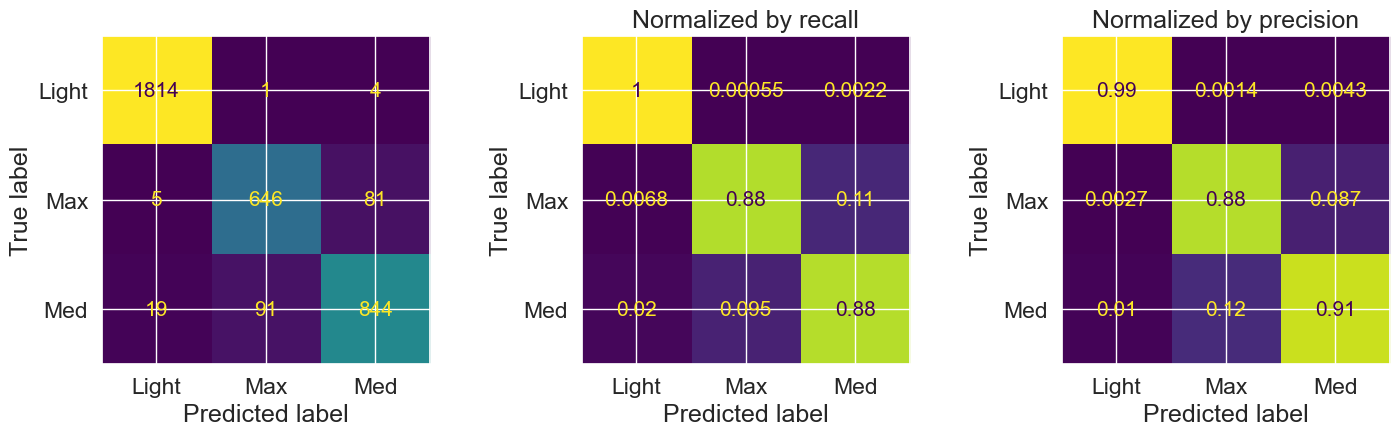

In [89]:
conf_matrix(y_test_steel, rForest_model.predict(dt_mapper.transform(x_test_steel)), display_labels = ['Light', 'Max', 'Med'])
plt.show()

In [91]:
pd.concat((pd.DataFrame(report(y_test_steel, rForest_model.predict(dt_mapper.transform(x_test_steel))), index=['Random forest model']),
pd.DataFrame({
    'Accuracy': 0.939515,
    'Precision': 0.929359,
    'Recall': 0.922794,
    'F-score': 0.925837,
}, index=['Decision Tree']))).T

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.2s finished


,Random forest model,Decision Tree
Accuracy,0.942653,0.939515
Precision,0.923595,0.929359
Recall,0.921487,0.922794
F-score,0.922474,0.925837


## Regression (forestfires)

In [27]:
numerical_forest = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH','wind']
target_forest = ['area']
categorical_forest = ['X', 'Y', 'month', 'day', 'rain']

### Preprocessing

In [28]:
column_transformer = TransformerList([FunctionTransformer(np.log1p, np.expm1), MinMaxScaler()])
y_train_forest_changed = column_transformer.fit_transform(y_train_forest)

In [29]:
forest_mapper = DataFrameMapper(
    gen_features(
        columns=[[i] for i in numerical_forest],
        classes=[StandardScaler]
    ) +
    gen_features(
        columns=[[i] for i in categorical_forest],
        classes=[TargetEncoder]
    ),
    df_out=True
)
forest_mapper.fit(x_train_forest, y_train_forest_changed)

DataFrameMapper(df_out=True, drop_cols=[],
                features=[(['FFMC'], [StandardScaler()], {}),
                          (['DMC'], [StandardScaler()], {}),
                          (['DC'], [StandardScaler()], {}),
                          (['ISI'], [StandardScaler()], {}),
                          (['temp'], [StandardScaler()], {}),
                          (['RH'], [StandardScaler()], {}),
                          (['wind'], [StandardScaler()], {}),
                          (['X'], [TargetEncoder()], {}),
                          (['Y'], [TargetEncoder()], {}),
                          (['month'], [TargetEncoder()], {}),
                          (['day'], [TargetEncoder()], {}),
                          (['rain'], [TargetEncoder()], {})])

### Model

In [30]:
regression_template = GradientBoostingRegressor(verbose=3, n_estimators=1000, n_iter_no_change=10, max_depth=None)

distributions = dict(loss = ['squared_error', 'absolute_error', 'huber', 'quantile' ],
                     learning_rate =sp.uniform(loc=0, scale=1),
                     n_estimators = [i for i in range(20, 150)],
                     criterion = ['friedman_mse', 'squared_error'],
                     min_samples_split =sp.uniform(loc=.01, scale=.1), 
                     min_samples_leaf = [i for i in range(2, 10)], 
                     max_leaf_nodes = [i for i in range(5, 80)],
                     init = [None, Ridge(), Lasso(), LinearSVR(), 'zero']
                     )
regression_selector = RandomizedSearchCV(regression_template, distributions, n_jobs=-1, cv=5, verbose=3, n_iter=500)
regression_model = regression_selector.fit(forest_mapper.transform(x_train_forest), y_train_forest_changed).best_estimator_
regression_model

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
      Iter       Train Loss   Remaining Time 
         1           0.0401            0.94s
         2           0.0401            0.78s
         3           0.0400            0.62s
         4           0.0400            0.56s
         5           0.0399            0.52s
         6           0.0399            0.50s
         7           0.0398            0.49s
         8           0.0397            0.49s
         9           0.0397            0.47s
        10           0.0396            0.46s
        11           0.0396            0.46s
        12           0.0395            0.45s
        13           0.0395            0.44s
        14           0.0394            0.43s
        15           0.0394            0.42s
        16           0.0393            0.40s
        17           0.0393            0.40s
        18           0.0392            0.40s
        19           0.0392            0.39s
        20           0.0391        

GradientBoostingRegressor(init=Ridge(), learning_rate=0.0019577851581913386,
                          max_depth=None, max_leaf_nodes=37, min_samples_leaf=9,
                          min_samples_split=0.04887725404297117,
                          n_estimators=106, n_iter_no_change=10, verbose=3)

In [31]:
forest_report = pd.DataFrame(report(forest_mapper.transform(x_train_forest), forest_mapper.transform(x_test_forest),y_test_forest, regression_model, column_transformer))
forest_report['Manualy selected']= [285.661506, 16.082957, 8.815164, -0.040543, -0.104250]
forest_report

,Test set,Manualy selected
MSE,228.607357,285.661506
RMSE,15.119767,16.082957
MAE,5.745661,8.815164
R^2,-0.037869,-0.040543
Adjusted R^2,-0.069241,-0.104250


### HistGradient

In [32]:
binary_clf_template = HistGradientBoostingRegressor(categorical_features=categorical_forest, warm_start=True, verbose=1, max_iter=100)

distributions = dict(
    loss = ['squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile' ],
    learning_rate =sp.uniform(loc=0, scale=1),
    l2_regularization =sp.uniform(loc=0, scale=2),
    min_samples_leaf = [i for i in range(2, 10)], 
    max_leaf_nodes = [i for i in range(5, 80)],
    max_depth =[i for i in range(8, 32)]
                     )
clf = RandomizedSearchCV(binary_clf_template, distributions, n_jobs=-1, cv=5, verbose=1, n_iter=500, random_state=42)
regression_model_sec = clf.fit(x_train_forest, y_train_forest).best_estimator_
regression_model_sec

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Binning 0.000 GB of training data: 0.014 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 77 leaves, max depth = 13, in 0.034s
[2/100] 1 tree, 77 leaves, max depth = 14, in 0.022s
[3/100] 1 tree, 77 leaves, max depth = 16, in 0.022s
[4/100] 1 tree, 77 leaves, max depth = 13, in 0.022s
[5/100] 1 tree, 77 leaves, max depth = 13, in 0.019s
[6/100] 1 tree, 77 leaves, max depth = 12, in 0.023s
[7/100] 1 tree, 77 leaves, max depth = 14, in 0.024s
[8/100] 1 tree, 77 leaves, max depth = 14, in 0.025s
[9/100] 1 tree, 77 leaves, max depth = 13, in 0.023s
[10/100] 1 tree, 77 leaves, max depth = 12, in 0.027s
[11/100] 1 tree, 77 leaves, max depth = 13, in 0.025s
[12/100] 1 tree, 77 leaves, max depth = 15, in 0.026s
[13/100] 1 tree, 77 leaves, max depth = 13, in 0.025s
[14/100] 1 tree, 77 leaves, max depth = 14, in 0.024s
[15/100] 1 tree, 77 leaves, max depth = 16, in 0.022s
[16/100] 1 tree, 77 leaves, max depth = 15, in 0.029s
[17/1

HistGradientBoostingRegressor(categorical_features=['X', 'Y', 'month', 'day',
                                                    'rain'],
                              l2_regularization=1.1873215824170769,
                              learning_rate=0.010131184027743378,
                              loss='absolute_error', max_depth=26,
                              max_leaf_nodes=77, min_samples_leaf=2, verbose=1,
                              warm_start=True)

In [33]:
regression_report(y_test_forest, regression_model_sec.predict(x_test_forest), x_train_forest)

{'MSE': 267.73490708687876,
 'RMSE': 16.362606977095023,
 'MAE': 8.741231428416837,
 'R^2': -0.21550721094534664,
 'Adjusted R^2': -0.2522479830646016}

### LGBM

In [34]:
regressin_template_lgbm = LGBMRegressor(n_jobs=-1)

distributions = dict(
    boosting_type = ['gdbt', 'dart', 'rf'],
    num_leaves = [i for i in range(3, 31)],
    max_depth = [i for i in range(10, 80)],
    learning_rate=sp.uniform(loc=0, scale=1),
    reg_alpha = sp.uniform(loc=0, scale=1),
    reg_lambda =sp.uniform(loc=0, scale=1),
    n_estimators = [i for i in range(100, 501, 50)],
    min_child_samples = [i for i in range(2, 19)]
)
regression_selector_lgmb = RandomizedSearchCV(regressin_template_lgbm, distributions, n_jobs=-1, cv=5, verbose=1, n_iter=200, random_state=42)
regression_model_lgmb = regression_selector_lgmb.fit(forest_mapper.transform(x_train_forest), y_train_forest_changed).best_estimator_
regression_model_lgmb

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 410, number of used features: 11
[LightGBM] [Info] Start training from score 0.168437


LGBMRegressor(boosting_type='dart', learning_rate=0.5026790232288615,
              max_depth=63, min_child_samples=6, n_jobs=-1, num_leaves=3,
              reg_alpha=0.23956189066697242, reg_lambda=0.1448948720912231)

In [35]:
report(forest_mapper.transform(x_train_forest), forest_mapper.transform(x_test_forest),y_test_forest, regression_model_lgmb, column_transformer)

,Test set
MSE,238.034477
RMSE,15.428366
MAE,6.201898
R^2,-0.080668
Adjusted R^2,-0.113333


## Binary Classification (diabetes)

In [36]:
numerical_diabetes = ['BMI']
categorical_diabetes = ['Age', 'Sex', 'HighChol', 'CholCheck', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP']

### Model

In [70]:
template_binary = HistGradientBoostingClassifier(categorical_features=categorical_diabetes, warm_start=True, verbose=1, max_iter=1000)
distributions = dict(
    learning_rate =sp.uniform(loc=0, scale=1),
    l2_regularization =sp.uniform(loc=0, scale=2),
    max_leaf_nodes =[i for i in range(8, 40)],
    max_depth =[i for i in range(3, 31)],
    min_samples_leaf = [i for i in range(2, 10)]
                     )
binary_selector = RandomizedSearchCV(template_binary, distributions, n_jobs=-1, cv=5, verbose=1, n_iter=500)
binary_model = binary_selector.fit(x_train_diabetes, y_train_diabetes).best_estimator_
binary_model

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Binning 0.006 GB of training data: 0.606 s
Binning 0.001 GB of validation data: 0.003 s
Fitting gradient boosted rounds:
[1/1000] 1 tree, 10 leaves, max depth = 4, train loss: 0.66607, val loss: 0.66726, in 0.042s
[2/1000] 1 tree, 10 leaves, max depth = 4, train loss: 0.64558, val loss: 0.64749, in 0.022s
[3/1000] 1 tree, 10 leaves, max depth = 4, train loss: 0.62872, val loss: 0.63109, in 0.025s
[4/1000] 1 tree, 10 leaves, max depth = 4, train loss: 0.61499, val loss: 0.61782, in 0.217s
[5/1000] 1 tree, 10 leaves, max depth = 4, train loss: 0.60324, val loss: 0.60610, in 0.410s
[6/1000] 1 tree, 10 leaves, max depth = 4, train loss: 0.59278, val loss: 0.59593, in 0.063s
[7/1000] 1 tree, 10 leaves, max depth = 4, train loss: 0.58454, val loss: 0.58796, in 0.029s
[8/1000] 1 tree, 10 leaves, max depth = 4, train loss: 0.57719, val loss: 0.58120, in 0.228s
[9/1000] 1 tree, 10 leaves, max depth = 6, train loss: 0.57074, val los

HistGradientBoostingClassifier(categorical_features=['Age', 'Sex', 'HighChol',
                                                     'CholCheck', 'Smoker',
                                                     'HeartDiseaseorAttack',
                                                     'PhysActivity', 'Fruits',
                                                     'Veggies',
                                                     'HvyAlcoholConsump',
                                                     'GenHlth', 'MentHlth',
                                                     'PhysHlth', 'DiffWalk',
                                                     'Stroke', 'HighBP'],
                               l2_regularization=0.8721892587241513,
                               learning_rate=0.11907024530497634, max_depth=14,
                               max_iter=1000, max_leaf_nodes=10,
                               min_samples_leaf=8, verbose=1, warm_start=True)

### Results

In [71]:
print(classification_report(y_test_diabetes, binary_model.predict(x_test_diabetes)))

              precision    recall  f1-score   support

         0.0       0.76      0.67      0.71      6126
         1.0       0.73      0.80      0.76      6678

    accuracy                           0.74     12804
   macro avg       0.74      0.74      0.74     12804
weighted avg       0.74      0.74      0.74     12804


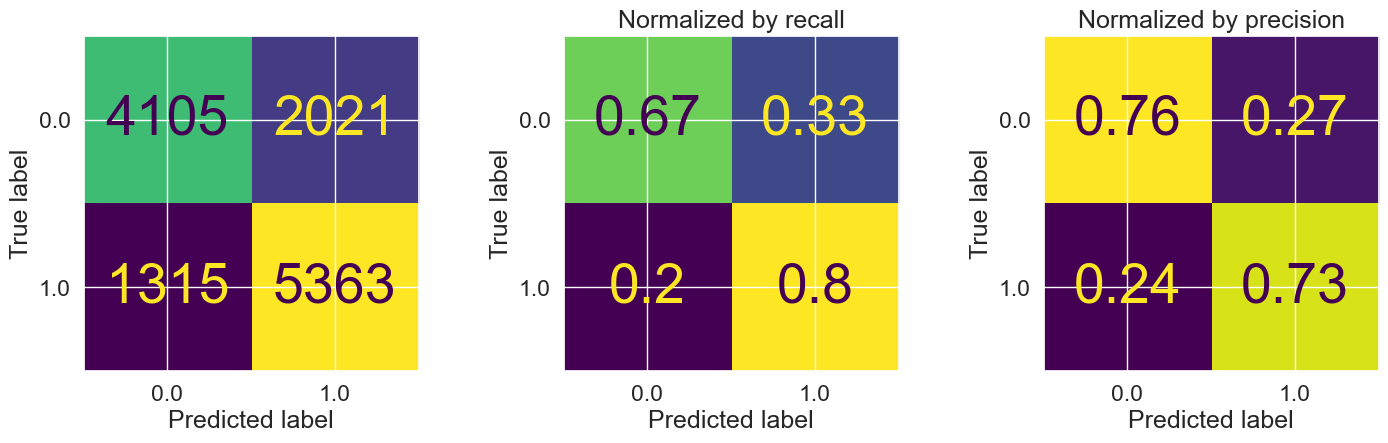

In [73]:
conf_matrix(y_test_diabetes, binary_model.predict(x_test_diabetes))
plt.show()

In [46]:
pd.concat((pd.DataFrame({
    'Accuracy': accuracy_score(y_test_diabetes, binary_model.predict(x_test_diabetes)),
    'Precision': precision_recall_fscore_support(y_test_diabetes, binary_model.predict(x_test_diabetes))[0][0],
    'Recall': precision_recall_fscore_support(y_test_diabetes, binary_model.predict(x_test_diabetes))[1][1],
    'F1': precision_recall_fscore_support(y_test_diabetes, binary_model.predict(x_test_diabetes))[2][1]
}, index=['Boosted model']),
pd.DataFrame({
    'Accuracy': 0.737035,
    'Precision': 0.7451572774124756,
    'Recall': 0.6844596800522363,
    'F1': 0.7135199523525908,
}, index=['Logistic Regression Model']))).T

,Boosted model,Logistic Regression Model
Accuracy,0.738051,0.737035
Precision,0.753568,0.745157
Recall,0.798293,0.684460
F1,0.760702,0.713520


## Multiclass classification (Steel industry)

In [40]:
categorical_steel = ['WeekStatus', 'Day_Of_Week', 'month', 'day', 'hour', 'quarter', 'Load_Type']
numerical_steel = df_steel.loc[:, [i not in categorical_steel + ['Date_Time'] for i in df_steel.columns]].columns.to_list()

['Usage_kWh',
 'Lagging_Current_Reactive.Power_kVarh',
 'Leading_Current_Reactive_Power_kVarh',
 'CO2(tCO2)',
 'Lagging_Current_Power_Factor',
 'Leading_Current_Power_Factor',
 'NSM']

### Preprocessing

In [41]:
steel_mapper = DataFrameMapper(
    gen_features(
        columns=[[i] for i in
                 df_steel.loc[:, [i not in ['Load_Type'] + ['Date_Time'] + numerical_steel for i in df_steel.columns]].columns],
        classes=[{'class': TargetEncoder,
                  'target_type': 'multiclass'}]
    )+
    gen_features(
        columns=[['Date_Time']],
        classes=[MonthExtractor, {'class': TargetEncoder,
                                  'target_type': 'multiclass'}],
        prefix='month_'
    )+ gen_features(
        columns=[['Date_Time']],
        classes=[HourExtractor, {'class': TargetEncoder,
                                 'target_type': 'multiclass'}],
        prefix='hour_'
    ) + gen_features(
        columns=[['Date_Time']],
        classes=[DayExtractor, {'class': TargetEncoder,
                                'target_type': 'multiclass'}],
        prefix='day_'
    ),
    df_out=True
)
steel_mapper.fit(x_train_steel, y_train_steel)

DataFrameMapper(df_out=True, drop_cols=[],
                features=[(['WeekStatus'],
                           [TargetEncoder(target_type='multiclass')], {}),
                          (['Day_Of_Week'],
                           [TargetEncoder(target_type='multiclass')], {}),
                          (['Date_Time'],
                           [<eds.MonthExtractor object at 0x000001F676057910>,
                            TargetEncoder(target_type='multiclass')],
                           {'prefix': 'month_'}),
                          (['Date_Time'],
                           [<eds.HourExtractor object at 0x000001F676055DE0>,
                            TargetEncoder(target_type='multiclass')],
                           {'prefix': 'hour_'}),
                          (['Date_Time'],
                           [<eds.DayExtractor object at 0x000001F676057D90>,
                            TargetEncoder(target_type='multiclass')],
                           {'prefix': 'day_'})])

### Model

In [42]:
multiclass_template = LGBMClassifier(n_jobs=-1)

distributions = dict(
    boosting_type = ['gdbt', 'dart', 'rf'],
    num_leaves = [i for i in range(3, 31)],
    max_depth = [i for i in range(10, 80)],
    learning_rate=sp.uniform(loc=0, scale=1),
    min_child_samples = [i for i in range(2, 19)],
    reg_alpha = sp.uniform(loc=0, scale=1),
    reg_lambda =sp.uniform(loc=0, scale=1),
    n_estimators = [i for i in range(100, 501, 50)],
)
multiclass_selector = RandomizedSearchCV(multiclass_template, distributions, n_jobs=-1, cv=5, verbose=1, n_iter=200, random_state=42)
multiclass_model = multiclass_selector.fit(steel_mapper.transform(x_train_steel), y_train_steel).best_estimator_
multiclass_model

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 31536, number of used features: 15
[LightGBM] [Info] Start training from score -0.662791
[LightGBM] [Info] Start training from score -1.573193
[LightGBM] [Info] Start training from score -1.282991


LGBMClassifier(boosting_type='dart', learning_rate=0.15105789178090023,
               max_depth=30, min_child_samples=16, n_estimators=300, n_jobs=-1,
               num_leaves=29, reg_alpha=0.9645204722702085,
               reg_lambda=0.7600940784380972)

### Results

In [43]:
print(classification_report(y_test_steel, multiclass_model.predict(steel_mapper.transform(x_test_steel)), digits=4)) 

              precision    recall  f1-score   support

  Light_Load     0.9798    0.9863    0.9830      1819
Maximum_Load     0.9062    0.8975    0.9019       732
 Medium_Load     0.9115    0.9067    0.9091       954

    accuracy                         0.9461      3505
   macro avg     0.9325    0.9302    0.9313      3505
weighted avg     0.9458    0.9461    0.9459      3505


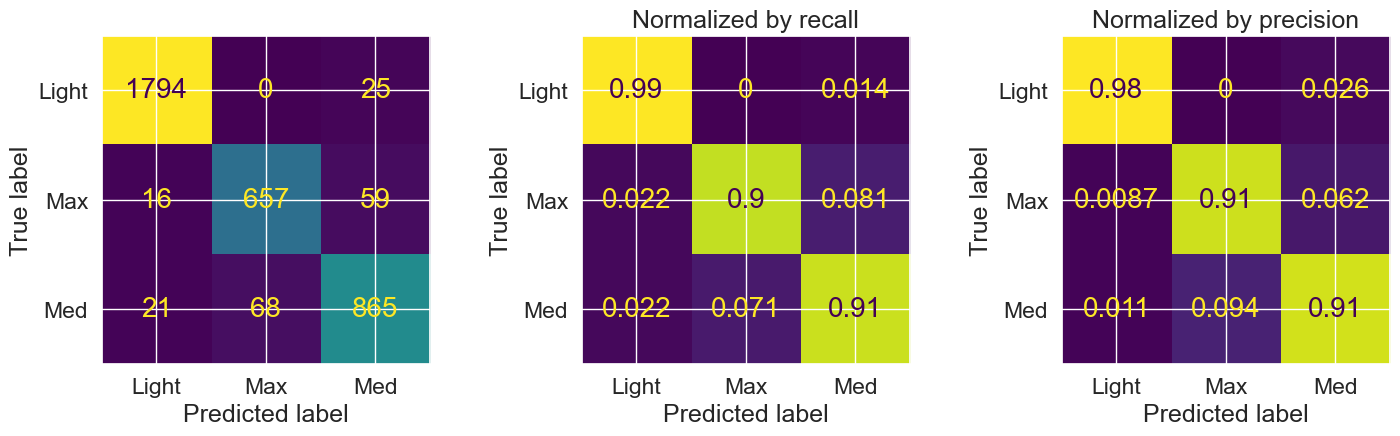

In [85]:
conf_matrix(y_test_steel, multiclass_model.predict(steel_mapper.transform(x_test_steel)), display_labels = ['Light', 'Max', 'Med'])
plt.rcParams.update({'font.size':15})
plt.show()

In [51]:
pd.concat((pd.DataFrame(report(y_test_steel, multiclass_model.predict(steel_mapper.transform(x_test_steel))), index=['Boosted model']),
pd.DataFrame({
    'Accuracy': 0.914408,
    'Precision': 0.893982,
    'Recall': 0.891635,
    'F-score': 0.892734,
}, index=['KNN Model']))).T

,Boosted model,KNN Model
Accuracy,0.946077,0.914408
Precision,0.932495,0.893982
Recall,0.930169,0.891635
F-score,0.931319,0.892734
